In [ ]:
# default_exp load_model

# Load Model

In [ ]:
#hide
from nbdev.showdoc import *
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#export
import torch 
import yaml
from fastcore.script import *
from swfd.recursos.model import *
import csv
import numpy as np
import os
import matplotlib.pyplot as plt
from swfd.web_scraping import *

loadModel(pathrun): Funcion que pasándole la dirección de una run saca su modelo

In [ ]:
#export
def loadModel(pathrun):
    pathyaml=str(pathrun)+"config.yaml"
    pathpth=str(pathrun)+"best.pth"
    config=yaml.safe_load(open(str(pathyaml)))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = NBeatsNet(device=device,stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
                  nb_blocks_per_stack=config["nb_blocks_per_stack"]["value"],
                  thetas_dims=config["thetas_dims"]["value"],
                  hidden_layer_units=config["hidden_layer_units"]["value"],
                  forecast_length=config["horizon"]["value"],backcast_length=config["lookback"]["value"])
    checkpoint = torch.load(pathpth,map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model, config["lookback"]["value"]


In [ ]:
#export
def getcsvdata(path,lookback):
    pathfoldercsv='/home/miguel/Escritorio/tfg_swf/csv/'
    nombredatos="2021-1-27-19sfuData.csv"
    #listadatos=np.array([])
    listadatos=[]
    try:       
        with open(str(pathfoldercsv)+str(nombredatos)) as csv_file:
            forecastcount=0
            for row in reversed(list(csv.reader(csv_file, delimiter=','))):
                if(forecastcount<lookback):
                    listadatos=np.append(listadatos,float(row[1]))
                    #listadatos.append(float(row[1]))
                    forecastcount=forecastcount+1
                    
    finally:
        csv_file.close()
    return listadatos


forecastModel(forecast): Funcion que devuelve lista con el directorio de todas las carpetas de un horizonte

In [ ]:
#export
def forecastModel(forecast): #Prediction
    #BUscar path de csv
    #Buscar path de la run
    pathfolderrun='/home/miguel/Escritorio/tfg_swf/csv/pth/'
    pathfoldercsv='/home/miguel/Escritorio/tfg_swf/csv/'
    pathfolderrun=pathfolderrun+"ensembleH"+str(forecast)
    pathfolderruns=[]
    contenido = os.listdir(pathfolderrun)
    for i in contenido:
        pathrun=pathfolderrun+"/"+str(i)+"/"
        pathfolderruns.append(pathrun)
    
    return pathfolderruns

runprediction(path,normalize): Funcion que hace la prediccion de una run concreta(carpeta individual)

In [ ]:
#export
def runprediction(path,normalize):
    net,lookback=loadModel(str(path))
    data=getcsvdata("",lookback)
    row = torch.Tensor([data/normalize])
    backcast,forecast = net(row)
    preds_tensor=(forecast.detach().numpy())*938.6
    return preds_tensor[0]
#runprediction('/home/miguel/Escritorio/tfg_swf/csv/pth/ensembleH7/sweep_run_16/',938.6)

sweepprediction(path,normalize): Funcion que se recorre cada carpeta de un horizonte y hace la predicion para cada run, devolviendo una lista con todas las predicciones.

In [ ]:
#export
def sweepprediction(path,normalize):
    prediction=[]
    runspath=forecastModel(7)
    for run in runspath:
        prediction.append(runprediction(run,normalize))
    return prediction
#prediction=sweepprediction('/home/miguel/Escritorio/tfg_swf/csv/pth/ensembleH7/',938.6)

sweepMeanVar(prediction): Funcion que hace la media y varianza de los valores predichos

In [ ]:
#export
def sweepMeanVar(prediction):
    matriz = [] 
    matrizmadre=[]
    meanlist=[]
    varlist=[]
    for i in range (0,7):
        matriz = []
        for j in range(0,90):
            matriz.append(prediction[j][i])
        matrizmadre.append(matriz)
    for element in matrizmadre:
        nparray=np.array(element,float)
        print("media",nparray.mean(),"    varianza",nparray.var())
        meanlist.append(nparray.mean())
        varlist.append(nparray.var())
    return meanlist,varlist

predecir(forecast): Funcion general que invoca a las demas funciones para cargar y ver el modelo

In [ ]:
#export
def predecir(forecast):
    normalize=938.6#Funcion web_scraping getMaxValueSfu(), funciona, pero parra ahorrar tiempo en las pruebas
    lookback=forecast*6
    forecastlist=[]
    
    data=getcsvdata("",lookback)
    
    prediction=sweepprediction('/home/miguel/Escritorio/tfg_swf/csv/pth/ensembleH7/',938.6)
    
    mean,var=sweepMeanVar(prediction)
    return prediction,mean,var


In [ ]:
#hide
predict,mean,var=predecir(7)

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=35, forecast_length=7, share_thetas=False) at @140362694275232
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=35, forecast_length=7, share_thetas=False) at @140358636351200
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=35, forecast_length=7, share_thetas=False) at @140358636350672
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=35, forecast_length=7, share_thetas=False) at @140362694279024
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=35, forecast_length=7, share_thetas=False) at @140358632943040
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=35, forecast_length=7, share_thetas=False) at @140358632943376
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, ba

/home/miguel/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=7, forecast_length=7, share_thetas=False) at @140358631374912
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=7, forecast_length=7, share_thetas=False) at @140358631375344
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=7, forecast_length=7, share_thetas=False) at @140358631375536
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=7, forecast_length=7, share_thetas=False) at @140358631377120
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=7, forecast_length=7, share_thetas=False) at @140358631376640
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=7, forecast_length=7, share_thetas=False) at @140358631377264
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, backcast

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=21, forecast_length=7, share_thetas=False) at @140362694275232
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=21, forecast_length=7, share_thetas=False) at @140358634791072
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=21, forecast_length=7, share_thetas=False) at @140358634794672
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=21, forecast_length=7, share_thetas=False) at @140362694275280
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=21, forecast_length=7, share_thetas=False) at @140358634793952
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=21, forecast_length=7, share_thetas=False) at @140358634792704
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, ba

     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=21, forecast_length=7, share_thetas=False) at @140358634833904
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=21, forecast_length=7, share_thetas=False) at @140358634834624
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=21, forecast_length=7, share_thetas=False) at @140358662677744
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=42, forecast_length=7, share_thetas=False) at @140358634835440
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=42, forecast_length=7, share_thetas=False) at @140358634834960
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=42, forecast_length=7, share_thetas=False) at @140358634835584
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=42, forecast_length=7, share_thetas=False) at @14035

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=28, forecast_length=7, share_thetas=False) at @140358632506032
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=28, forecast_length=7, share_thetas=False) at @140358632505600
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=28, forecast_length=7, share_thetas=False) at @140358632508624
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=28, forecast_length=7, share_thetas=False) at @140358632506464
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=28, forecast_length=7, share_thetas=False) at @140358632505696
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=28, forecast_length=7, share_thetas=False) at @140358632508768
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, ba

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=28, forecast_length=7, share_thetas=False) at @140358618224336
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=28, forecast_length=7, share_thetas=False) at @140358618226352
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=28, forecast_length=7, share_thetas=False) at @140358618225104
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=28, forecast_length=7, share_thetas=False) at @140358618224816
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=28, forecast_length=7, share_thetas=False) at @140358618224384
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=28, forecast_length=7, share_thetas=False) at @140358618222800
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, ba

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=42, forecast_length=7, share_thetas=False) at @140358618884944
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=42, forecast_length=7, share_thetas=False) at @140358618883552
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=42, forecast_length=7, share_thetas=False) at @140358618883792
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=42, forecast_length=7, share_thetas=False) at @140358618883984
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=42, forecast_length=7, share_thetas=False) at @140358618883024
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=42, forecast_length=7, share_thetas=False) at @140358618884608
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, ba

     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=35, forecast_length=7, share_thetas=False) at @140358632851008
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=35, forecast_length=7, share_thetas=False) at @140358632851728
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=35, forecast_length=7, share_thetas=False) at @140358635558992
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=35, forecast_length=7, share_thetas=False) at @140358635558176
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=35, forecast_length=7, share_thetas=False) at @140358618224624
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=35, forecast_length=7, share_thetas=False) at @140358618226256
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=35, forecast_length=7, share_thetas=False) at @14035

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=28, forecast_length=7, share_thetas=False) at @140358634791936
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=28, forecast_length=7, share_thetas=False) at @140358634794384
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=28, forecast_length=7, share_thetas=False) at @140358634793712
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=28, forecast_length=7, share_thetas=False) at @140358634791216
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=28, forecast_length=7, share_thetas=False) at @140358634794912
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=28, forecast_length=7, share_thetas=False) at @140358634791120
| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, ba

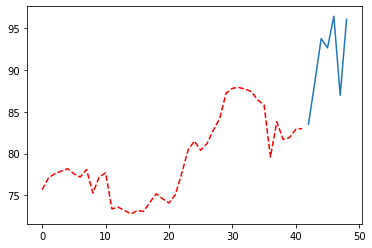

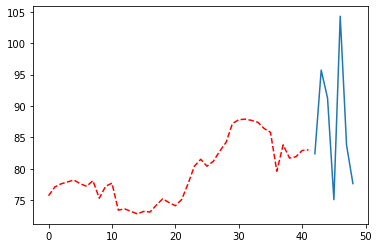

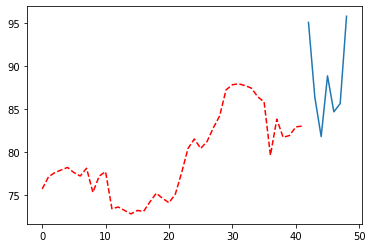

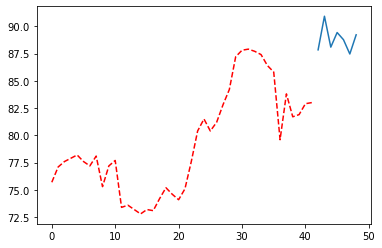

In [ ]:
#hide
data=getcsvdata("",7*6)
forecastlist=[]
for i in range(0,horizon):
    forecastlist.append(lookback+i)
    i=i+1
plt.plot(data,"r--",forecastlist,prediction[0])
plt.show()
plt.plot(data,"r--",forecastlist,prediction[1])
plt.show()
plt.plot(data,"r--",forecastlist,prediction[89])
plt.show()
plt.plot(data,"r--",forecastlist,mean)
plt.show()

In [ ]:
#hide
"""horizon=7
backlog=horizon*6
data=data
maxvaluesfu=938.6#Funcion web_scraping

net,lookback=loadModel('/home/miguel/Escritorio/tfg_swf/csv/pth/ensembleH7/sweep_run_2/')
data=getcsvdata("",lookback)
print(type(data))
row = torch.Tensor([data/938.6])
backcast,forecast = net(row)
preds_tensor=(forecast.detach().numpy())*938.6
forecastlist=[]


for i in range(0,horizon):
    forecastlist.append(lookback+i)
    i=i+1
#plt.plot(data,"r--",forecastlist,preds_tensor[0])#,preds_tensor[0])
plt.plot(data,"r--",forecastlist,arraymedia)#,preds_tensor[0])
plt.show()"""

'horizon=7\nbacklog=horizon*6\ndata=data\nmaxvaluesfu=938.6#Funcion web_scraping\n\nnet,lookback=loadModel(\'/home/miguel/Escritorio/tfg_swf/csv/pth/ensembleH7/sweep_run_2/\')\ndata=getcsvdata("",lookback)\nprint(type(data))\nrow = torch.Tensor([data/938.6])\nbackcast,forecast = net(row)\npreds_tensor=(forecast.detach().numpy())*938.6\nforecastlist=[]\n\n\nfor i in range(0,horizon):\n    forecastlist.append(lookback+i)\n    i=i+1\n#plt.plot(data,"r--",forecastlist,preds_tensor[0])#,preds_tensor[0])\nplt.plot(data,"r--",forecastlist,arraymedia)#,preds_tensor[0])\nplt.show()'

In [ ]:
#hide
maxvaluesdf=getMaxValueSfu()
print(maxvaluesdf)

938.6
